# Real-Time Data Pipeline and Warehouse for Sales Using PySpark

This project demonstrates a comprehensive real-time data warehouse solution for processing and analyzing incoming sales data from raw files.

## Project Overview

This project provides solutions for:

1. **Streaming Data Pipelines**: Efficiently processing and transforming incoming sales data in real-time.
2. **Data Warehouse**: Storing and managing the processed data for efficient querying and analysis.
3. **Data Analysis**: Analyzing the stored data to derive meaningful insights.

## Tools and Technologies Used

1. **Apache Spark (PySpark)**: Utilized for Structured Streaming to handle real-time data processing.
2. **SQL**: Employed for querying and managing data within the data warehouse.
3. **Python**: Used for data manipulation and visualization with libraries such as Pandas and Matplotlib.

## ETL Life Cycle

The project implements the full ETL (Extract, Transform, Load) life cycle:

1. **Extract**: Raw sales data is ingested from various sources.
2. **Transform**: Data is processed and transformed in real-time using PySpark Structured Streaming.
3. **Load**: Transformed data is loaded into the data warehouse for storage and further analysis.

This project showcases an end-to-end solution for real-time data warehousing, ensuring that sales data is processed, stored, and analyzed efficiently.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sales import generate_new_sales

In [2]:
#generate new sales data
generate_new_sales(1000, "sales")

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

your 131072x1 screen size is bogus. expect trouble
24/07/29 07:20:44 WARN Utils: Your hostname, DESKTOP-GJHDSFN resolves to a loopback address: 127.0.1.1; using 172.23.108.242 instead (on interface eth0)
24/07/29 07:20:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/29 07:20:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, col, expr, current_timestamp, lit, when

In [9]:
path_source = "./datasets/sales"
path_raw_sales = "./spark-warehouse/raw_sales"
path_customers = "./spark-warehouse/customers"
path_products = "./spark-warehouse/products"
path_sales = "./spark-warehouse/sales"
path_checkpoint = "./checkpoints/"

def get_checkpoint(name: str) -> str:
    return path_checkpoint + name

In [10]:
import shutil
shutil.rmtree("spark-warehouse", ignore_errors=True)
shutil.rmtree("checkpoints", ignore_errors=True)

In [11]:
# display the source data
df = (spark.read
.csv(path_source, header=True, inferSchema=True, sep=",")
)
df.show()

+--------+-----------+--------------------+------------+--------------------+----------+--------------------+-------------+----------------+----------+
|order_id|customer_id|       customer_name|customer_age|    customer_country|product_id|        product_name|product_price|product_quantity|order_date|
+--------+-----------+--------------------+------------+--------------------+----------+--------------------+-------------+----------------+----------+
|     614|        251|         Robert Ryan|          35|                Niue|       229|  Vivid Water Bottle|          360|              47|2022-07-30|
|     918|         36|Katherine Richardson|          16|Antarctica (the t...|       702|          Power Soap|          234|              47|2022-07-30|
|     418|        291|          Sarah Holt|          45|United States of ...|       657|         Hydro Watch|          126|              90|2022-07-30|
|     834|        842|       Matthew Johns|          56| Antigua and Barbuda|        24|

In [12]:
df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- customer_country: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_price: integer (nullable = true)
 |-- product_quantity: integer (nullable = true)
 |-- order_date: date (nullable = true)



In [13]:
# create an expression for validating the raw data
is_valid = expr("""
    (order_id is not null) and
    (customer_id is not null) and
    (product_id is not null) and
    (order_date is not null)
""").alias("is_valid")
is_valid

Column<'(((order_id IS NOT NULL) AND (customer_id IS NOT NULL)) AND ((product_id IS NOT NULL) AND (order_date IS NOT NULL))) AS is_valid'>

In [14]:
# create streaming pipeline on source data
(
    spark.readStream
    .option('header', 'true')
    .schema(df.schema)
    .csv(path_source)
    .select("*",
        col("_metadata.file_path").alias("source_file"),
        current_timestamp().alias("processing_time"),
        is_valid
    )
    .writeStream
    .format("parquet")
    .option("truncate", "false")
    .option("checkpointLocation", get_checkpoint("raw_sales"))
    .option("path", path_raw_sales)
    .start()
)

24/07/29 07:30:32 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [15]:
# display the raw data [field added (is_valid)]
df_raw_sales = spark.read.parquet(path_raw_sales).orderBy(col('processing_time').desc())
df_raw_sales.show()

+--------+-----------+--------------------+------------+--------------------+----------+--------------------+-------------+----------------+----------+--------------------+--------------------+--------+
|order_id|customer_id|       customer_name|customer_age|    customer_country|product_id|        product_name|product_price|product_quantity|order_date|         source_file|     processing_time|is_valid|
+--------+-----------+--------------------+------------+--------------------+----------+--------------------+-------------+----------------+----------+--------------------+--------------------+--------+
|     614|        251|         Robert Ryan|          35|                Niue|       229|  Vivid Water Bottle|          360|              47|2022-07-30|file:/root/pyspar...|2024-07-29 07:30:...|    true|
|     918|         36|Katherine Richardson|          16|Antarctica (the t...|       702|          Power Soap|          234|              47|2022-07-30|file:/root/pyspar...|2024-07-29 07:30

In [16]:
df_raw_sales.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- customer_country: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_price: integer (nullable = true)
 |-- product_quantity: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- source_file: string (nullable = false)
 |-- processing_time: timestamp (nullable = false)
 |-- is_valid: boolean (nullable = false)



In [17]:
# create streaming pipeline on raw data for customers
(
    spark.readStream
    .format("parquet")
    .schema(df_raw_sales.schema)
    .parquet(path_raw_sales)
    .select(
        col("customer_id").alias("id"),
        col("customer_name").alias("name"),
        col("customer_age").alias("age"),
        col("customer_country").alias("country"),
        col("processing_time")
    )
    .where("is_valid = true")
    .writeStream
    .format("parquet")
    .option("truncate", "false")
    .option("checkpointLocation", get_checkpoint("customers"))
    .option("path", path_customers)
    .start()
)

24/07/29 07:32:40 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [18]:
# display the customers data
df_customers = spark.read.parquet(path_customers).orderBy(col('processing_time').desc())
df_customers.show(truncate=False)

+---+--------------------+---+--------------------------------------------+----------------------+
|id |name                |age|country                                     |processing_time       |
+---+--------------------+---+--------------------------------------------+----------------------+
|251|Robert Ryan         |35 |Niue                                        |2024-07-29 07:30:32.75|
|36 |Katherine Richardson|16 |Antarctica (the territory South of 60 deg S)|2024-07-29 07:30:32.75|
|291|Sarah Holt          |45 |United States of America                    |2024-07-29 07:30:32.75|
|842|Matthew Johns       |56 |Antigua and Barbuda                         |2024-07-29 07:30:32.75|
|84 |Amber Clark         |36 |Peru                                        |2024-07-29 07:30:32.75|
|654|James Sandoval      |42 |Pakistan                                    |2024-07-29 07:30:32.75|
|850|Allison Richardson  |41 |Moldova                                     |2024-07-29 07:30:32.75|
|225|Kiara

In [19]:
df_customers.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- processing_time: timestamp (nullable = true)



In [20]:
# create streaming pipeline on raw data for products
(
    spark.readStream
    .format("parquet")
    .schema(df_raw_sales.schema)
    .parquet(path_raw_sales)
    .select(
        col("product_id").alias("id"),
        col("product_name").alias("name"),
        col("product_price").alias("price"),
        col("processing_time")
    )
    .where("is_valid = true")
    .writeStream
    .format("parquet")
    .option("truncate", "false")
    .option("checkpointLocation", get_checkpoint("products"))
    .option("path", path_products)
    .start()
)

24/07/29 07:33:14 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [21]:
# display the products data
df_products = spark.read.parquet(path_products).orderBy(col('processing_time').desc())
df_products.show()

+---+--------------------+-----+--------------------+
| id|                name|price|     processing_time|
+---+--------------------+-----+--------------------+
|229|  Vivid Water Bottle|  360|2024-07-29 07:30:...|
|702|          Power Soap|  234|2024-07-29 07:30:...|
|657|         Hydro Watch|  126|2024-07-29 07:30:...|
| 24|        Plush Pillow|  223|2024-07-29 07:30:...|
|369|    Speed Headphones|   54|2024-07-29 07:30:...|
| 98|      Aqua Glassware|  232|2024-07-29 07:30:...|
|473|        Turbo Pillow|  242|2024-07-29 07:30:...|
|159|        Turbo Candle|   78|2024-07-29 07:30:...|
|588|         Elite Watch|   51|2024-07-29 07:30:...|
|371|      Comfort Camera|  152|2024-07-29 07:30:...|
| 79|  Gourmet Hair Dryer|  107|2024-07-29 07:30:...|
|780|Gourmet Coffee Maker|  186|2024-07-29 07:30:...|
|408|     Luxe Sleep Mask|  458|2024-07-29 07:30:...|
|625|      Elite Lipstick|  200|2024-07-29 07:30:...|
|702|        Ultra Vacuum|  369|2024-07-29 07:30:...|
|450|           Elite Mop|  

In [22]:
df_products.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- processing_time: timestamp (nullable = true)



In [23]:
# create streaming pipeline on raw data for sales
(
    spark.readStream
    .format("parquet")
    .schema(df_raw_sales.schema)
    .parquet(path_raw_sales)
    .select(
        col("order_id").alias("id"),
        col("customer_id"),
        col("product_id"),
        col("product_quantity"),
        col("order_date"),
        col("processing_time")
    )
    .where("is_valid = true")
    .writeStream
    .format("parquet")
    .option("truncate", "false")
    .option("checkpointLocation", get_checkpoint("sales"))
    .option("path", path_sales)
    .start()
)

24/07/29 07:33:37 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [24]:
# display the sales data
df_sales = spark.read.parquet(path_sales).orderBy(col('processing_time').desc())
df_sales.show()

+---+-----------+----------+----------------+----------+--------------------+
| id|customer_id|product_id|product_quantity|order_date|     processing_time|
+---+-----------+----------+----------------+----------+--------------------+
|614|        251|       229|              47|2022-07-30|2024-07-29 07:30:...|
|918|         36|       702|              47|2022-07-30|2024-07-29 07:30:...|
|418|        291|       657|              90|2022-07-30|2024-07-29 07:30:...|
|834|        842|        24|              41|2022-07-30|2024-07-29 07:30:...|
|414|         84|       369|              29|2022-07-31|2024-07-29 07:30:...|
|134|        654|        98|              16|2022-08-01|2024-07-29 07:30:...|
|487|        850|       473|              63|2022-08-01|2024-07-29 07:30:...|
|179|        225|       159|              64|2022-08-02|2024-07-29 07:30:...|
|377|          1|       588|              26|2022-08-02|2024-07-29 07:30:...|
|513|        490|       371|              67|2022-08-02|2024-07-

In [25]:
df_sales.printSchema()

root
 |-- id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_quantity: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- processing_time: timestamp (nullable = true)



In [26]:
# create a window for unique up-to-date records
window = Window.partitionBy('id').orderBy(col('processing_time').desc())
partition = row_number().over(window)
partition

Column<'row_number() OVER (PARTITION BY id ORDER BY processing_time DESC NULLS LAST unspecifiedframe$())'>

In [27]:
# unique up-to-date customers
df_customers = spark.read.parquet(path_customers).orderBy(col('processing_time').desc())
dim_customers = (
    df_customers
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'name', 'age', 'country')
)
dim_customers.show(truncate=False)

+---+--------------------+---+----------------------------+
|id |name                |age|country                     |
+---+--------------------+---+----------------------------+
|1  |Jeremy Hunt         |29 |Timor-Leste                 |
|2  |Tiffany Zuniga      |37 |Poland                      |
|4  |James Dennis Jr.    |30 |Norfolk Island              |
|7  |David Lozano        |15 |Iraq                        |
|9  |Chelsea Booker      |19 |United Arab Emirates        |
|11 |Ashley Keith        |41 |Azerbaijan                  |
|12 |Jason Mercer        |54 |Morocco                     |
|14 |Michael King        |50 |Iraq                        |
|16 |Dalton Drake        |34 |New Caledonia               |
|17 |Alicia Rose         |21 |Kuwait                      |
|18 |Christine Johnson   |29 |Congo                       |
|19 |Kelly James         |29 |Cote d'Ivoire               |
|20 |Mr. David Lee MD    |31 |Maldives                    |
|25 |Matthew Fox         |36 |Argentina 

In [28]:
# unique up-to-date products
df_products = spark.read.parquet(path_products).orderBy(col('processing_time').desc())
dim_products = (
    df_products
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'name', 'price')
)
dim_products.show(truncate=False)

+---+------------------+-----+
|id |name              |price|
+---+------------------+-----+
|4  |Clean Glassware   |460  |
|5  |Vibe Coffee Maker |296  |
|8  |Lumina Sleep Mask |187  |
|9  |Eco Coffee Maker  |360  |
|10 |Luxe Sleep Mask   |216  |
|14 |Ultra Glassware   |380  |
|15 |Aqua Mop          |86   |
|16 |Lumina Stand      |120  |
|17 |Crystal Glassware |495  |
|19 |Power Water Filter|379  |
|20 |Serenity Snack Box|354  |
|23 |Elegance Footwear |309  |
|24 |Plush Pillow      |223  |
|26 |Glimmer Candle    |275  |
|28 |Clean Thermostat  |12   |
|29 |Style Lipstick    |463  |
|31 |Vibe Headphones   |475  |
|33 |Vivid Lipstick    |396  |
|34 |Fresh Hair Trimmer|107  |
|35 |Style Footwear    |252  |
+---+------------------+-----+
only showing top 20 rows



In [29]:
# unique up-to-date sales
df_sales = spark.read.parquet(path_sales).orderBy(col('processing_time').desc())
dim_sales = (
    df_sales
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'customer_id', 'product_id', 'product_quantity', 'order_date')
)
dim_sales.show(truncate=False)

+---+-----------+----------+----------------+----------+
|id |customer_id|product_id|product_quantity|order_date|
+---+-----------+----------+----------------+----------+
|1  |34         |675       |41              |2023-06-05|
|2  |823        |381       |66              |2024-03-11|
|3  |569        |664       |8               |2024-03-27|
|4  |973        |73        |16              |2023-08-11|
|5  |768        |542       |32              |2023-12-31|
|6  |221        |596       |4               |2024-02-14|
|7  |627        |314       |91              |2023-04-18|
|8  |642        |601       |36              |2023-06-25|
|9  |749        |363       |77              |2022-12-12|
|10 |107        |379       |26              |2024-06-14|
|11 |353        |260       |17              |2023-05-09|
|12 |655        |422       |13              |2023-10-21|
|13 |201        |24        |10              |2023-12-16|
|14 |16         |947       |93              |2024-03-05|
|15 |985        |181       |51 

# Data analysis using Data warehouse

In [30]:
df_customers = spark.read.parquet(path_customers).orderBy(col('processing_time').desc())
dim_customers = (
    df_customers
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'name', 'age', 'country')
)


df_products = spark.read.parquet(path_products).orderBy(col('processing_time').desc())
dim_products = (
    df_products
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'name', 'price')
)


df_sales = spark.read.parquet(path_sales).orderBy(col('processing_time').desc())
dim_sales = (
    df_sales
    .withColumn('rn', partition)
    .where('rn == 1')
    .select('id', 'customer_id', 'product_id', 'product_quantity', 'order_date')
)

dim_customers.createOrReplaceTempView("customers")
dim_products.createOrReplaceTempView("products")
dim_sales.createOrReplaceTempView("sales")
spark.sql(
    """
    select
        sales.id as order_id,
        sales.customer_id,
        sales.product_id,
        sales.order_date,
        sales.product_quantity,
        customers.name as customer_name,
        customers.age as customer_age,
        customers.country as customer_country,
        products.name as product_name,
        products.price as product_price
    from sales
        left join customers
            on sales.customer_id = customers.id
        left join products
            on sales.product_id = products.id
    """
).show()

+--------+-----------+----------+----------+----------------+-----------------+------------+--------------------+--------------------+-------------+
|order_id|customer_id|product_id|order_date|product_quantity|    customer_name|customer_age|    customer_country|        product_name|product_price|
+--------+-----------+----------+----------+----------------+-----------------+------------+--------------------+--------------------+-------------+
|       1|         34|       675|2023-06-05|              41|   Michaela Moore|          16|        Sierra Leone|      Vibe Snack Box|           99|
|       2|        823|       381|2024-03-11|              66|  Alicia Anderson|          21|   Equatorial Guinea|     Power Snack Box|          420|
|       3|        569|       664|2024-03-27|               8|    Jennifer Wade|          35|              Brazil|  Gourmet Sleep Mask|          268|
|       4|        973|        73|2023-08-11|              16|        John Mann|          38|Cocos (Keeling

In [31]:
sales_by_year_month = spark.sql(
    """
    select
        YEAR(sales.order_date) as year,
        MONTH(sales.order_date) as month,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join products
            on sales.product_id = products.id
    group by year, month
    order by year, month
    
    """
)
sales_by_year_month.show()

+----+-----+-----------+------------+
|year|month|total_sales|total_orders|
+----+-----+-----------+------------+
|2022|    7|      49967|           5|
|2022|    8|     623323|          46|
|2022|    9|     514651|          37|
|2022|   10|     625792|          49|
|2022|   11|     484036|          39|
|2022|   12|     439770|          37|
|2023|    1|     517176|          34|
|2023|    2|     448538|          30|
|2023|    3|     570095|          48|
|2023|    4|     668076|          44|
|2023|    5|     436745|          36|
|2023|    6|     524993|          31|
|2023|    7|     633927|          47|
|2023|    8|     394044|          43|
|2023|    9|     536927|          48|
|2023|   10|     517638|          48|
|2023|   11|     512456|          45|
|2023|   12|     677544|          49|
|2024|    1|     697040|          48|
|2024|    2|     582464|          41|
+----+-----+-----------+------------+
only showing top 20 rows



In [32]:
sales_by_product = spark.sql(
    """
    select
        products.name as product_name,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join products
            on sales.product_id = products.id
    group by product_name
    order by product_name
    
    """
)
sales_by_product.show()

+-------------------+-----------+------------+
|       product_name|total_sales|total_orders|
+-------------------+-----------+------------+
|      Aqua Backpack|      94422|           4|
|       Aqua Blanket|       1690|           2|
|        Aqua Candle|      28050|           1|
|  Aqua Coffee Maker|      11232|           1|
|     Aqua Glassware|      42538|           7|
|     Aqua Knife Set|      14350|           2|
|          Aqua Lock|      22502|           5|
| Aqua Massage Chair|      14062|           1|
|           Aqua Mop|       4730|           1|
|       Aqua Pet Bed|      23944|           3|
|      Aqua Purifier|       7624|           2|
|    Aqua Shower Gel|       3096|           2|
|          Aqua Soap|     101530|           3|
|       Aqua Sweater|      51772|           5|
|    Aqua Thermostat|      10138|           1|
|        Aqua Vacuum|       2772|           1|
|        Breeze Lock|      16404|           3|
|     Breeze Pet Bed|      46070|           4|
|      Breeze

In [33]:
sales_by_country = spark.sql(
    """
    select
        customers.country as country,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join customers
            on sales.customer_id = customers.id
        left join products
            on sales.product_id = products.id
    group by country
    order by country
    
    """
)
sales_by_country.show()

+--------------------+-----------+------------+
|             country|total_sales|total_orders|
+--------------------+-----------+------------+
|         Afghanistan|       3705|           1|
|             Albania|      94493|           6|
|      American Samoa|      66012|           5|
|             Andorra|      44034|           3|
|              Angola|     120195|           7|
|            Anguilla|      26137|           3|
|Antarctica (the t...|      49389|           3|
| Antigua and Barbuda|      66365|           4|
|           Argentina|      68695|           6|
|               Aruba|      25290|           4|
|           Australia|      40187|           4|
|             Austria|      78786|           8|
|          Azerbaijan|     125087|           5|
|             Bahamas|     103114|           5|
|             Bahrain|      77568|           4|
|          Bangladesh|       7029|           2|
|            Barbados|      19302|           2|
|             Belarus|      41839|      

Text(0, 0.5, 'Country')

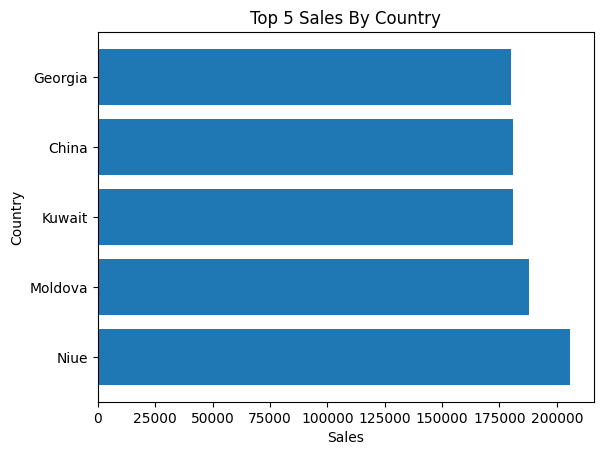

In [40]:
sales_by_country_ = sales_by_country.toPandas()
sales_by_country_ = sales_by_country_.sort_values('total_sales', ascending=False)
plt.barh(sales_by_country_['country'][:5], sales_by_country_['total_sales'][:5])
plt.title("Top 5 Sales By Country")
plt.xlabel("Sales")
plt.ylabel('Country')

In [41]:
sales_by_year = spark.sql(
    """
    select
        YEAR(sales.order_date) as year,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join products
            on sales.product_id = products.id
    group by year
    order by year
    
    """
)
sales_by_year.show()

+----+-----------+------------+
|year|total_sales|total_orders|
+----+-----------+------------+
|2022|    2737539|         213|
|2023|    6438159|         503|
|2024|    3818986|         284|
+----+-----------+------------+



Text(0, 0.5, 'Sales')

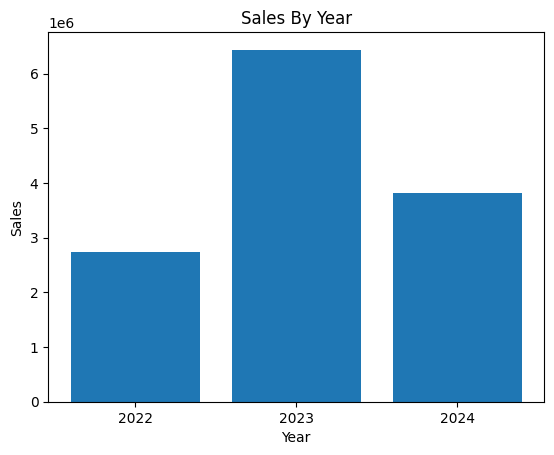

In [42]:
sales_by_year_ = sales_by_year.toPandas()
plt.bar(sales_by_year_['year'].astype(str), sales_by_year_['total_sales'])
plt.title("Sales By Year")
plt.xlabel("Year")
plt.ylabel('Sales')

In [48]:
sales_by_month = spark.sql(
    """
    select
        MONTH(sales.order_date) as month,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join products
            on sales.product_id = products.id
    group by month
    order by month
    
    """
)
sales_by_month.show()

+-----+-----------+------------+
|month|total_sales|total_orders|
+-----+-----------+------------+
|    1|    1214216|          82|
|    2|    1031002|          71|
|    3|    1091276|          93|
|    4|    1146860|          84|
|    5|    1122754|          80|
|    6|     939487|          66|
|    7|    1122908|          83|
|    8|    1017367|          89|
|    9|    1051578|          85|
|   10|    1143430|          97|
|   11|     996492|          84|
|   12|    1117314|          86|
+-----+-----------+------------+



Text(0, 0.5, 'Sales')

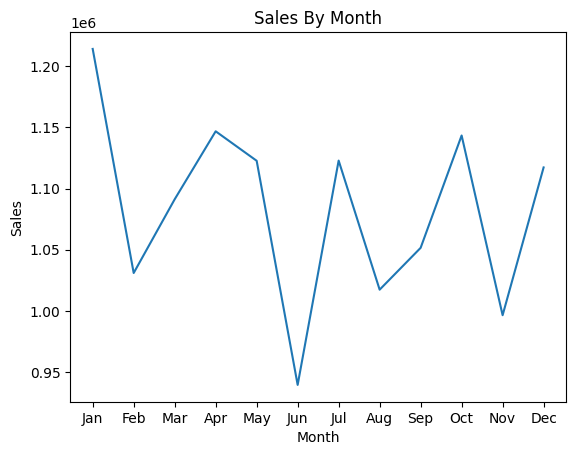

In [50]:
sales_by_month_ = sales_by_month.toPandas()
sales_by_month_['month_name'] = pd.to_datetime(sales_by_month_['month'], format="%m").dt.strftime('%b')
plt.plot(sales_by_month_['month_name'], sales_by_month_['total_sales'])
plt.title("Sales By Month")
plt.xlabel("Month")
plt.ylabel('Sales')

Text(0, 0.5, 'Orders')

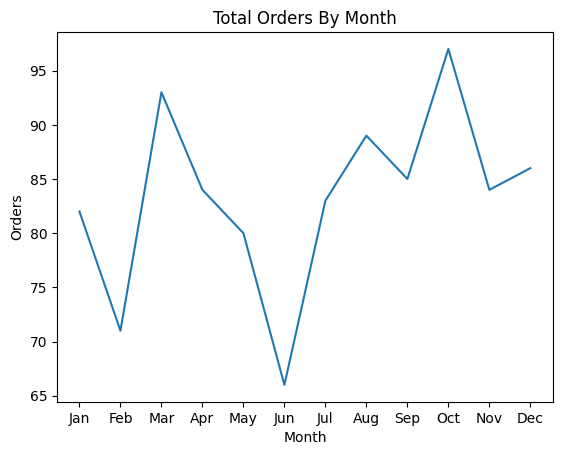

In [52]:
plt.plot(sales_by_month_['month_name'], sales_by_month_['total_orders'])
plt.title("Total Orders By Month")
plt.xlabel("Month")
plt.ylabel('Orders')

In [53]:
sales_by_month_country = spark.sql(
    """
    select
        MONTH(sales.order_date) as month,
        customers.country as country,
        SUM(sales.product_quantity * products.price) as total_sales,
        count(*) as total_orders
    from sales
        left join products
            on sales.product_id = products.id
        left join customers
            on sales.customer_id = customers.id
    group by month, country
    order by month, country
    
    """
)
sales_by_month_country.show()

+-----+--------------------+-----------+------------+
|month|             country|total_sales|total_orders|
+-----+--------------------+-----------+------------+
|    1|              Angola|      45930|           2|
|    1|Antarctica (the t...|       7125|           1|
|    1|               Aruba|       2170|           1|
|    1|             Austria|      10560|           1|
|    1|             Bahrain|      34440|           1|
|    1|              Bhutan|       1413|           1|
|    1|              Brazil|      31079|           3|
|    1|British Virgin Is...|       2328|           1|
|    1|   Brunei Darussalam|      10650|           1|
|    1|        Burkina Faso|       1911|           1|
|    1|             Burundi|      20064|           1|
|    1|            Cambodia|      45375|           2|
|    1|            Cameroon|       2431|           1|
|    1|      Cayman Islands|      24876|           2|
|    1|               Chile|      31287|           2|
|    1|Cocos (Keeling) I...|